In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
import pickle
from datetime import datetime, timedelta

from imblearn.over_sampling import SMOTE
from collections import Counter

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [3]:
##### EPIDEMIC dataset #####
## Cases and Testing
cases_malaysia = pickle.load(open('pickle_files/cases_malaysia.pkl', 'rb'))
cases_state = pickle.load(open('pickle_files/cases_state.pkl', 'rb')) 

tests_malaysia = pickle.load(open('pickle_files/tests_malaysia.pkl', 'rb')) 
tests_state = pickle.load(open('pickle_files/tests_state.pkl', 'rb')) 

## Deaths
deaths_malaysia = pickle.load(open('pickle_files/deaths_malaysia.pkl', 'rb'))
deaths_state = pickle.load(open('pickle_files/deaths_state.pkl', 'rb')) 

## Static Data
population = pd.read_csv('dataset/static/population_moh.csv')

##### VACCINATION & REGISTRATION dataset #####
## Adverse Events Following Immunization (AEFI)
aefi = pickle.load(open('pickle_files/aefi.pkl', 'rb'))
aefi_serious = pickle.load(open('pickle_files/aefi_serious.pkl', 'rb'))

## Vaccination
vax_malaysia = pickle.load(open('pickle_files/vax_malaysia.pkl', 'rb'))
vax_state = pickle.load(open('pickle_files/vax_state.pkl', 'rb'))

## Registration
vaxreg_malaysia = pickle.load(open('pickle_files/vaxreg_malaysia.pkl', 'rb'))
vaxreg_state = pickle.load(open('pickle_files/vaxreg_state.pkl', 'rb'))

##### MYSEJAHTERA dataset #####
checkin_malaysia = pickle.load(open('pickle_files/checkin_malaysia.pkl', 'rb'))
checkin_malaysia_time = pickle.load(open('pickle_files/checkin_malaysia_time.pkl', 'rb'))
checkin_state = pickle.load(open('pickle_files/checkin_state.pkl', 'rb'))
trace_malaysia = pickle.load(open('pickle_files/trace_malaysia.pkl', 'rb'))

# 1.0 Time-Series Regression for Daily COVID Cases Forecasting

In order to deploy appropriate movement control measures, how can the government accurately predict of weely new cases based on past data?


## 1.1 LSTM-based RNN

In [4]:
cases_malaysia.head()

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_pvax,cases_fvax,cases_child,cases_adolescent,cases_adult,cases_elderly
0,2020-01-25,4,4,0,4,0,0,0,0,0,1,0
1,2020-01-26,0,0,0,4,0,0,0,0,0,0,0
2,2020-01-27,0,0,0,4,0,0,0,0,0,0,0
3,2020-01-28,0,0,0,4,0,0,0,0,0,0,0
4,2020-01-29,3,3,0,7,0,0,0,1,0,2,0


In [5]:
cases_malaysia.shape

(620, 12)

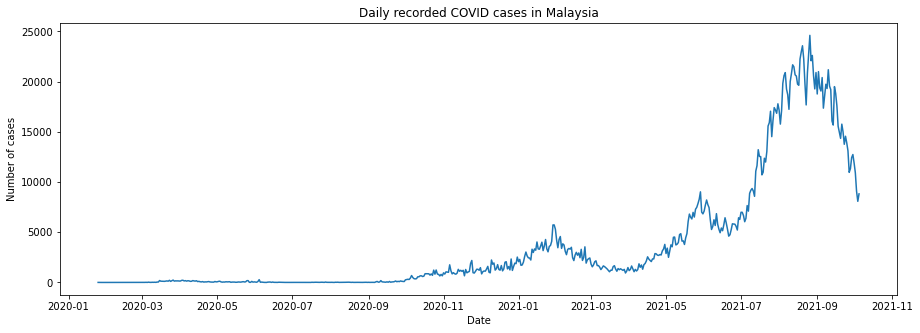

In [6]:
cases_malaysia['date'] = cases_malaysia['date'].astype('datetime64[ns]')

plt.figure(figsize=(15, 5))
plt.plot(cases_malaysia['date'], cases_malaysia['cases_new'])
plt.title('Daily recorded COVID cases in Malaysia')
plt.xlabel('Date')
plt.ylabel('Number of cases')
plt.show()

In [7]:
train_df = cases_malaysia[cases_malaysia['date'] < '2021-07'] # before July 2021
test_df = cases_malaysia[cases_malaysia['date'] >= '2021-07'] # after

print(train_df.shape)
print(test_df.shape)

(523, 12)
(97, 12)


In [8]:
train_set = train_df.iloc[:, 1: 2].values 
test_set = test_df.iloc[:, 1: 2].values 

print(train_set.shape)
print(test_set.shape)

(523, 1)
(97, 1)


In [9]:
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train_set)

In [10]:
# 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(train_scaled)):
    X_train.append(train_scaled[i-60: i, 0])
    y_train.append(train_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# reshape X_train
X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))

In [11]:
print(X_train.shape)
print(y_train.shape)

(463, 60, 1)
(463,)


In [12]:
regressor = Sequential()

regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))
regressor.add(Dense(1))

regressor.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [13]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [14]:
regressor.fit(x=X_train, y=y_train, batch_size=32, epochs=100)

Epoch 1/100
15/15 [==============================] - 6s 57ms/step - loss: 0.0234
Epoch 2/100
15/15 [==============================] - 1s 54ms/step - loss: 0.0105
Epoch 3/100
15/15 [==============================] - 1s 77ms/step - loss: 0.0074
Epoch 4/100
15/15 [==============================] - 1s 57ms/step - loss: 0.0059
Epoch 5/100
15/15 [==============================] - 1s 54ms/step - loss: 0.0056
Epoch 6/100
15/15 [==============================] - 1s 58ms/step - loss: 0.0056
Epoch 7/100
15/15 [==============================] - 1s 63ms/step - loss: 0.0059
Epoch 8/100
15/15 [==============================] - 1s 55ms/step - loss: 0.0052
Epoch 9/100
15/15 [==============================] - 1s 93ms/step - loss: 0.0046
Epoch 10/100
15/15 [==============================] - 1s 69ms/step - loss: 0.0050
Epoch 11/100
15/15 [==============================] - 1s 61ms/step - loss: 0.0047
Epoch 12/100
15/15 [==============================] - 1s 94ms/step - loss: 0.0040
Epoch 13/100
15/15 [=====

In [15]:
total_df = cases_malaysia['cases_new']

inputs = total_df[len(total_df) - len(test_df) - 60:].values

# reshape data to only have 1 col
inputs = inputs.reshape(-1, 1)

# scale input
inputs = sc.transform(inputs)

In [16]:
X_test = []
y_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60: i, 0])
    y_test.append(inputs[i, 0])


X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, newshape = (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, newshape = (y_test.shape[0], 1))

In [17]:
prediction = regressor.predict(X_test)

predicted_cases = sc.inverse_transform(prediction)
real_cases = sc.inverse_transform(y_test)

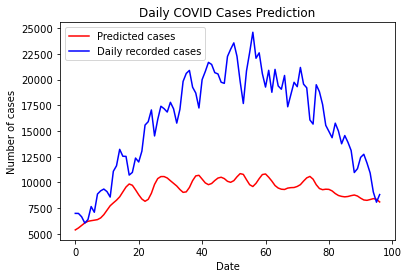

In [18]:
plt.plot(predicted_cases, color='red', label = 'Predicted cases')
plt.plot(real_cases, color='blue', label = 'Daily recorded cases')

plt.title('Daily COVID Cases Prediction')
plt.xlabel('Date')
plt.ylabel('Number of cases')
plt.legend()
plt.show()

In [19]:
rmse = math.sqrt(mean_squared_error(predicted_cases, real_cases))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7740.403


## 1.2 Multivariate LSTM-based RNN

There are various datasets that might have impact to the number of daily COVID cases. Therefore, a feature selection is required to get the attributes with higher correlation.

The available datasets are:

| Dataset          | Start date | End date   | Shape (row x column) |
| ---------------- | ---------- | ---------- | -------------------- |
| cases_malaysia   | 2020-01-25 | 2021-10-05 | (620, 12)            |
| tests_malaysia   | 2020-01-24 | 2021-10-02 | (618, 3)             |
| deaths_malaysia  | 2020-03-17 | 2021-10-05 | (568, 8)             |
| checkin_malaysia | 2020-12-01 | 2021-10-05 | (309, 4)             |
| vax_malaysia     | 2021-02-24 | 2021-10-05 | (224, 19)            |
| vaxreg_malaysia  | 2021-06-24 | 2021-10-05 | (104, 11)            |

We will generate a heatmap to visualize the correlationship of each attributes with `cases_new` (daily COVID cases). Before that, we will be merging a few datasets together. Since tests_malaysia, deaths_malaysia, and checkin_malaysia have a similar time range, we will merge them together along with cases_malaysia. On the other hand, vax_malaysia and vaxreg_malaysia have a more relatively shorter time range. Hence, we will merge them with the `cases_new` column separately in another DataFrame.


In [20]:
cases_malaysia['date'] = cases_malaysia['date'].astype('datetime64[ns]')
tests_malaysia['date'] = tests_malaysia['date'].astype('datetime64[ns]')
deaths_malaysia['date'] = deaths_malaysia['date'].astype('datetime64[ns]')

# merge cases_state and tests_state together
df_cases_tests = (pd.merge(cases_malaysia, tests_malaysia, on='date', how='inner', indicator=True)).set_index('date')
df_cases_tests.drop(['_merge'], axis=1, inplace=True)

# merge deaths_sta
df_cases_tests_deaths = (pd.merge(df_cases_tests, deaths_malaysia, on='date', how='inner', indicator=True)).set_index('date')
df_cases_tests_deaths.drop(['_merge'], axis=1, inplace=True)

# merge checkins
df_all = (pd.merge(df_cases_tests_deaths, checkin_malaysia, on='date', how='inner', indicator=True)).set_index('date')
df_all.drop(['_merge'], axis=1, inplace=True)

# reset index
df_all.reset_index(inplace = True)
#df_all.head()

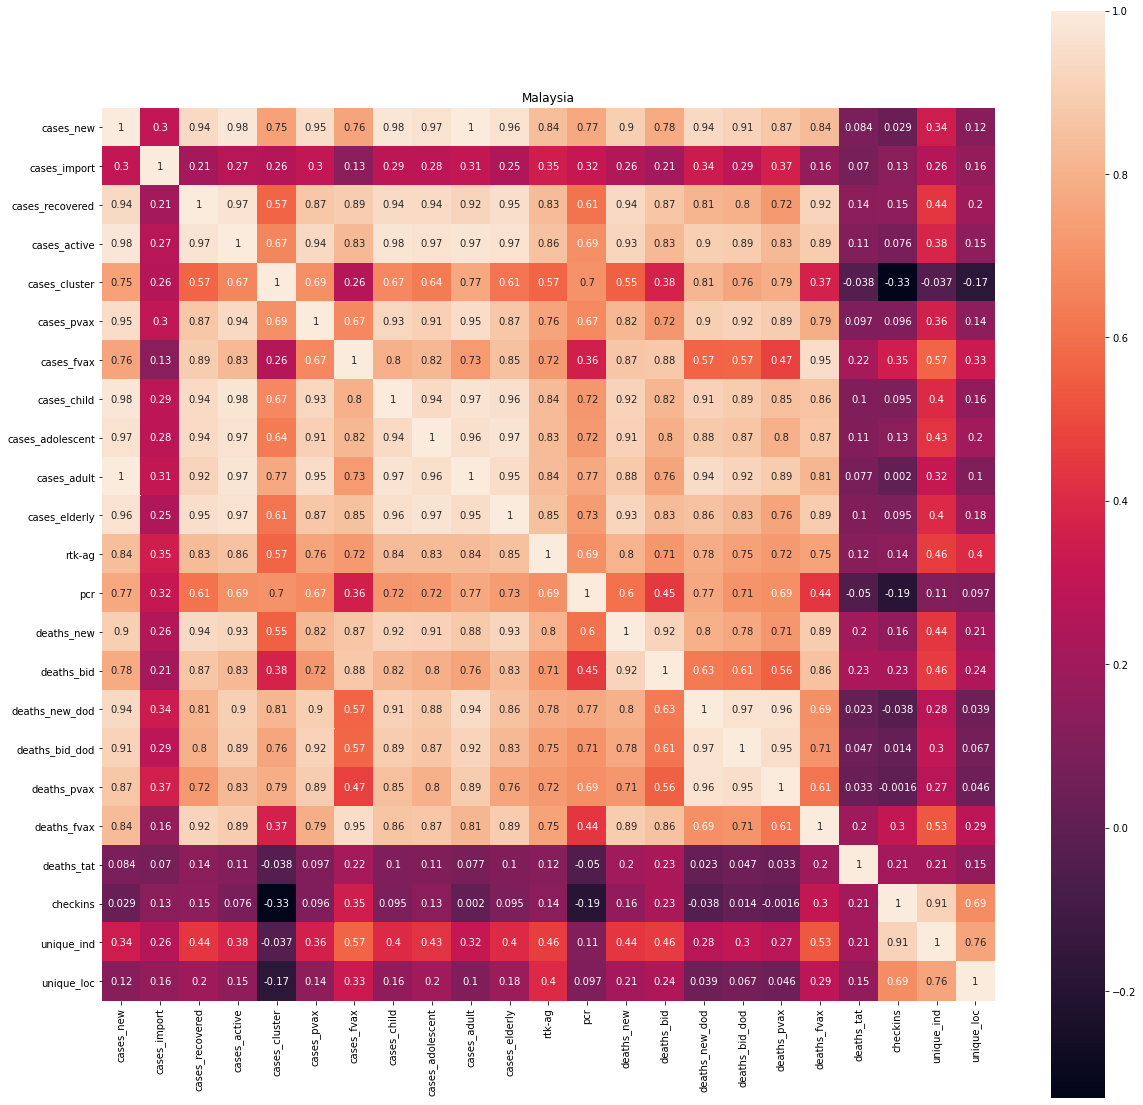

In [21]:
corr = df_all.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr,square=True,annot=True)
plt.title('Malaysia')
plt.show()

In [22]:
# merge cases_malaysia and vax_malaysia
df_cases_vax = (pd.merge(cases_malaysia[['date', 'cases_new']], vax_malaysia, on='date', how='inner', indicator=True)).set_index('date')
df_cases_vax.drop(['_merge'], axis=1, inplace=True)

# merge again with vaxreg_malaysia
df_cases_vax_vaxreg = (pd.merge(df_cases_vax, vaxreg_malaysia, on='date', how='inner', indicator=True)).set_index('date')
df_cases_vax_vaxreg.drop(['_merge'], axis=1, inplace=True)

# reset index
df_cases_vax_vaxreg.reset_index(inplace = True)
# df_cases_vax_vaxreg.head()

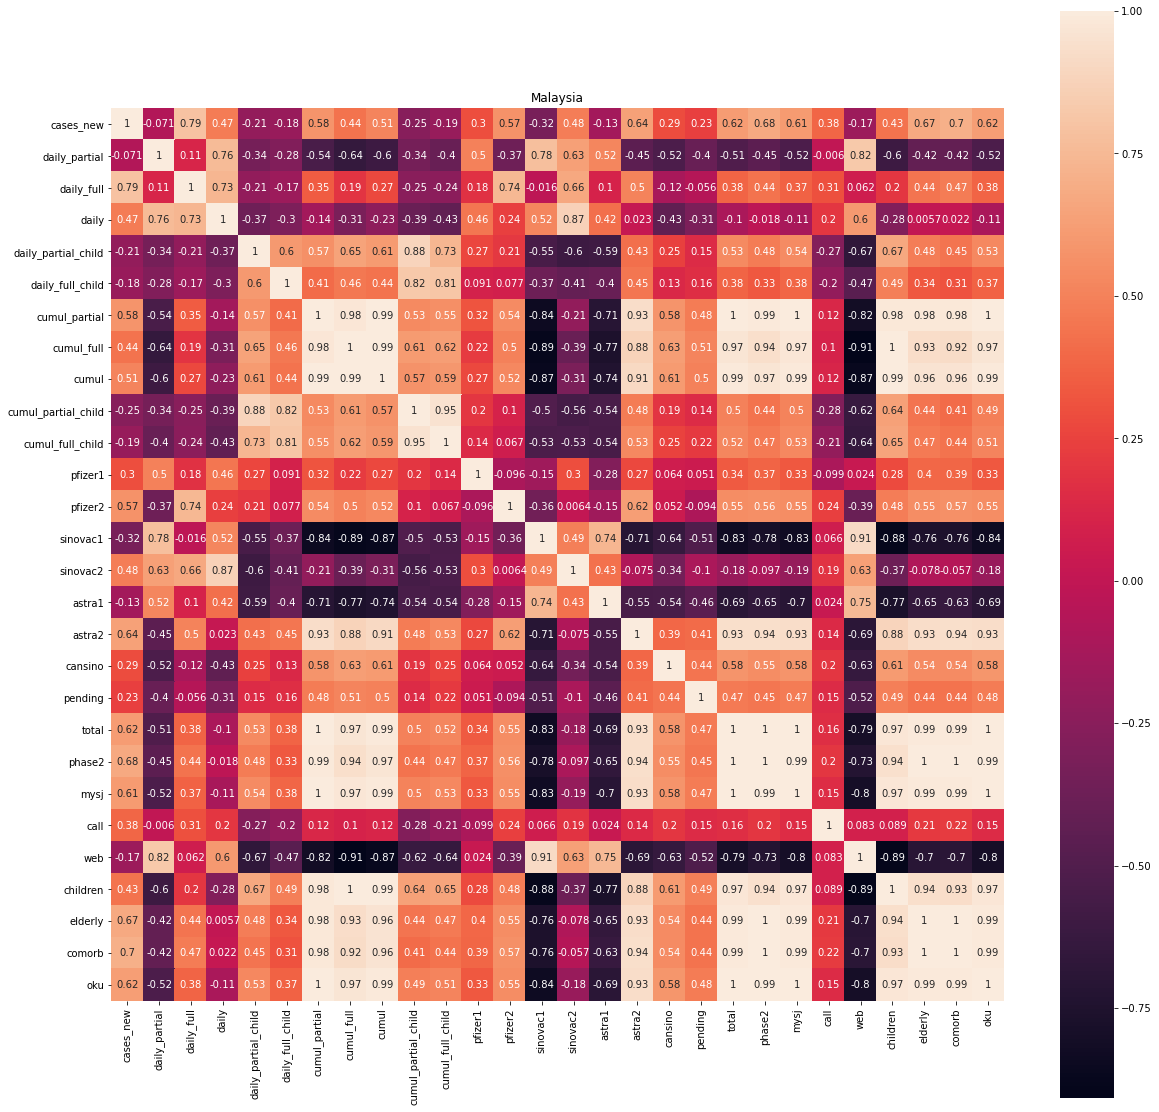

In [23]:
corr2 = df_cases_vax_vaxreg.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr2,square=True,annot=True)
plt.title('Malaysia')
plt.show()

After observing the correlationship between `cases_new` and other attributes from various datasets (cases_malaysia, tests_malaysia, deaths_malaysia, checkin_malaysia, vax_malaysia and vaxreg_malaysia). We found that the features with higher correlation (>= 0.9 positively or negatively) are:

`cases_recovered`, 
`cases_active`, 
`cases_pvax`, 
`cases_child`, 
`cases_adolescent`, 
`cases_adult`, 
`cases_elderly`, 
`deaths_new`, 
`deaths_new_dod`, and 
`deaths_bid_dod`.

Since all of the features came from the cases_malaysia and deaths_malaysia dataset, we will merge both dataset again to get a wider time range of data.


In [24]:
# merge cases_malaysia and vax_malaysia
df_cases_deaths = (pd.merge(cases_malaysia[['date', 'cases_new', 'cases_recovered', 'cases_active', 'cases_pvax', 'cases_child', 'cases_adolescent', 'cases_adult', 'cases_elderly']], 
                            deaths_malaysia[['date', 'deaths_new', 'deaths_new_dod', 'deaths_bid_dod']], 
                            on='date', how='inner', indicator=True)
                  ).set_index('date')
df_cases_deaths.drop(['_merge'], axis=1, inplace=True)
df_cases_deaths.reset_index(inplace = True)

print(df_cases_deaths.shape)
df_cases_deaths.head()

(568, 12)


,date,cases_new,cases_recovered,cases_active,cases_pvax,cases_child,cases_adolescent,cases_adult,cases_elderly,deaths_new,deaths_new_dod,deaths_bid_dod
0,2020-03-17,120,7,622,0,5,3,90,22,2,2,0
1,2020-03-18,117,11,728,0,4,8,79,25,0,0,0
2,2020-03-19,110,15,823,0,6,6,78,20,0,0,0
3,2020-03-20,130,12,940,0,2,6,97,22,1,1,0
4,2020-03-21,153,27,1062,0,7,3,106,34,4,4,0


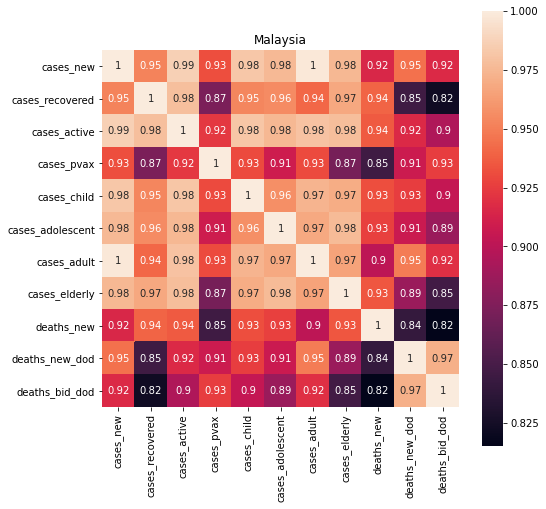

In [25]:
plt.figure(figsize=(8,8))
sns.heatmap(df_cases_deaths.corr(),square=True,annot=True)
plt.title('Malaysia')
plt.show()

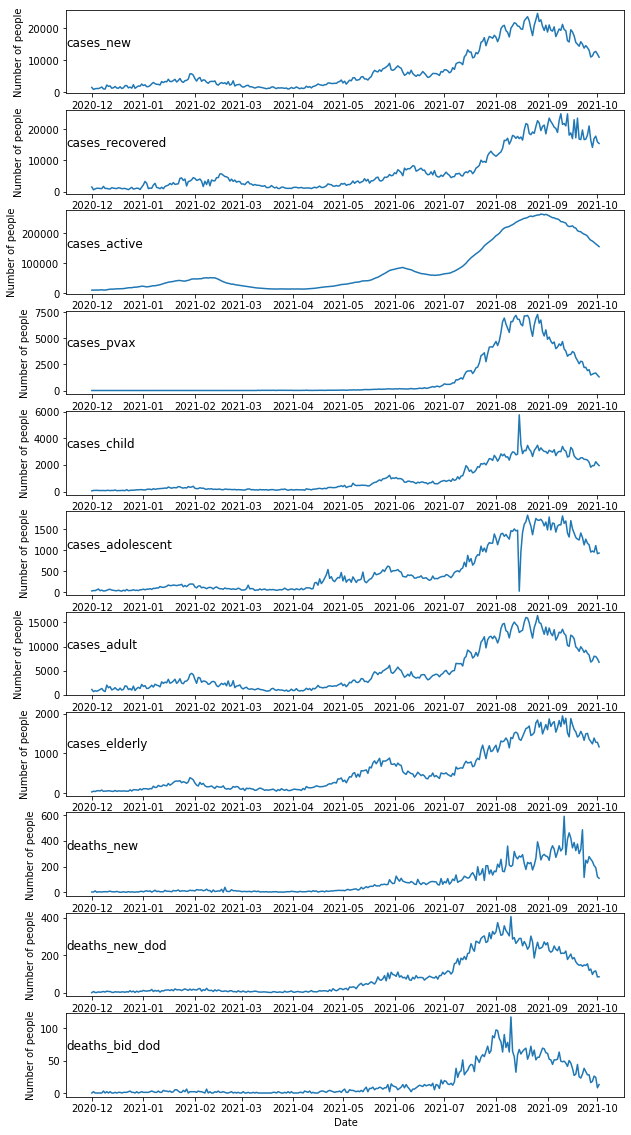

In [26]:
features = ['cases_new', 'cases_recovered', 'cases_active', 'cases_pvax', 'cases_child', 'cases_adolescent', 'cases_adult', 'cases_elderly', 'deaths_new', 'deaths_new_dod', 'deaths_bid_dod']

plt.figure(figsize=(10, 20))
for i in range(len(features)):
    plt.subplot(len(features),1,1+i)
    plt.plot(df_all['date'], df_all[features[i]])
    plt.title(features[i], y= 0.5, loc='left')
    plt.xlabel("Date")
    plt.ylabel("Number of people")
plt.show()

In [27]:
input_feature = df_cases_deaths[features]
input_data = input_feature.values
input_data.shape

(568, 11)

In [28]:
# normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
input_data = scaler.fit_transform(input_data)
input_data.shape

(568, 11)

In [29]:
lookback = 30
total_size = len(df_cases_deaths)

X=[]
y=[]
for i in range(0, total_size-lookback): # loop data set with margin 50 as we use 50 days data for prediction
    t=[]
    for j in range(0, lookback): # loop for 50 days
        current_index = i+j
        t.append(input_data[current_index, :]) # get data margin from 50 days with marging i
    X.append(t)
    y.append(input_data[lookback+i, 4])

X, y= np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(538, 30, 11)
(538,)


* We will get last 50 days for testing (predict). 

In [30]:
test_size = 50

X_test = X[-test_size:]
y_test = y[-test_size:]

X_rest = X[:-test_size]
y_rest = y[:-test_size]

X_train, X_valid, y_train, y_valid = train_test_split(X_rest, y_rest, test_size=0.15, random_state=1)

X_train = X_train.reshape(X_train.shape[0], lookback, len(features))
X_valid = X_valid.reshape(X_valid.shape[0], lookback, len(features))
X_test = X_test.reshape(X_test.shape[0], lookback, len(features))

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(414, 30, 11)
(74, 30, 11)
(50, 30, 11)


In [31]:
regressor = Sequential()
#add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], len(features))))
regressor.add(Dropout(rate = 0.2))

##add 2nd lstm layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 4th lstm layer
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))

##add output layer
regressor.add(Dense(units = 1))

regressor.compile(optimizer='adam', loss='mean_squared_error')

In [32]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 30, 50)            12400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 50)            20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)               

In [33]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

regressor.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid), callbacks=callbacks)

Epoch 1/100
52/52 [==============================] - 8s 58ms/step - loss: 0.0027 - val_loss: 0.0011

Epoch 00001: val_loss improved from inf to 0.00111, saving model to model.h5
Epoch 2/100
52/52 [==============================] - 2s 32ms/step - loss: 0.0025 - val_loss: 0.0012

Epoch 00002: val_loss did not improve from 0.00111
Epoch 3/100
52/52 [==============================] - 2s 33ms/step - loss: 0.0016 - val_loss: 0.0015

Epoch 00003: val_loss did not improve from 0.00111
Epoch 4/100
52/52 [==============================] - 2s 34ms/step - loss: 0.0020 - val_loss: 0.0014

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00004: val_loss did not improve from 0.00111
Epoch 5/100
52/52 [==============================] - 2s 33ms/step - loss: 0.0014 - val_loss: 3.8233e-04

Epoch 00005: val_loss improved from 0.00111 to 0.00038, saving model to model.h5
Epoch 6/100
52/52 [==============================] - 2s 30ms/step - loss: 0.0011 - val_loss: 3.642

In [34]:
predicted_value = regressor.predict(X_test)

In [42]:
# invert scaling for prediction
inv_yhat = np.concatenate((predicted_value, X_test[:,:1,-10:].reshape((50, 10))), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
y_test = y_test.reshape((y_test.shape[0], 1))
inv_y = np.concatenate((y_test, X_test[:,:1,-10:].reshape((50, 10))), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

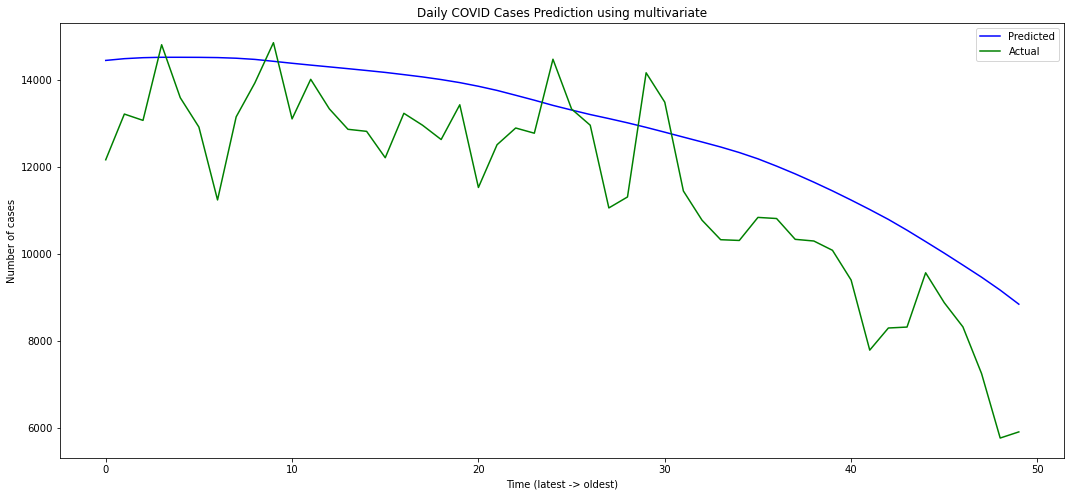

In [43]:
plt.figure(figsize=(18, 8))
plt.plot(inv_yhat, color='blue', label='Predicted')
plt.plot(inv_y, color='green', label='Actual')
plt.title("Daily COVID Cases Prediction using multivariate")
plt.xlabel("Time (latest -> oldest)")
plt.ylabel("Number of cases")
plt.legend()
plt.show()

In [40]:
rmse = math.sqrt(mean_squared_error(inv_yhat, inv_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1640.952
